In [19]:
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_dt

# If df is not already loaded, uncomment:
# from pathlib import Path
# df = pd.read_csv(Path("../data") / "cleaned_master.csv", low_memory=False)

def rebuild_datetime(df):
    # 0) Start from whatever we have
    if "transaction_time" in df.columns:
        s = pd.to_datetime(df["transaction_time"], errors="coerce", infer_datetime_format=True)
    else:
        s = pd.Series(pd.NaT, index=df.index)

    # 1) If the parsed dates look suspicious (all ~1970 or very few distinct days), try better sources
    suspicious = (
        is_dt(s)
        and s.notna().any()
        and (
            (s.dt.year.min() <= 1971 and s.dt.year.max() <= 1971)  # stuck near 1970
            or (s.dt.normalize().nunique() <= 2)                   # not enough distinct dates
        )
    )

    if suspicious:
        print("Detected suspicious 1970-ish dates; rebuilding from other columns…")

        built = False

        # A) ISO year+week -> Monday
        if {"year","week"}.issubset(df.columns) and not built:
            y = pd.to_numeric(df["year"], errors="coerce").astype("Int64").astype(str)
            w = pd.to_numeric(df["week"], errors="coerce").astype("Int64").astype(str).str.zfill(2)
            s2 = pd.to_datetime(y + w + "1", format="%G%V%u", errors="coerce")
            if s2.notna().mean() > 0.60:
                s = s2; built = True
                print("✓ Rebuilt from year+week")

        # B) year + month + day triplet
        if {"year","month","day"}.issubset(df.columns) and not built:
            s2 = pd.to_datetime(
                dict(
                    year=pd.to_numeric(df["year"], errors="coerce"),
                    month=pd.to_numeric(df["month"], errors="coerce"),
                    day=pd.to_numeric(df["day"], errors="coerce"),
                ),
                errors="coerce",
            )
            if s2.notna().mean() > 0.60:
                s = s2; built = True
                print("✓ Rebuilt from year/month/day")

        # C) Try any other date-like columns (string or epoch seconds/ms/us/ns)
        if not built:
            for c in [c for c in df.columns if c not in {"transaction_time"} and any(k in c.lower() for k in ["date","time","timestamp"])]:
                # string parse
                s2 = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
                if s2.notna().mean() > 0.60 and s2.dt.year.between(1990,2035).mean() > 0.5:
                    s = s2; built = True; print(f"✓ Rebuilt from {c} (string)"); break
                # epoch variants
                if pd.api.types.is_numeric_dtype(df[c]) and not built:
                    for unit in ["s","ms","us","ns"]:
                        s2 = pd.to_datetime(df[c], errors="coerce", unit=unit)
                        if s2.notna().mean() > 0.60 and s2.dt.year.between(1990,2035).mean() > 0.5:
                            s = s2; built = True; print(f"✓ Rebuilt from {c} as epoch ({unit})"); break
                if built: break

        if not built:
            print("⚠ Could not rebuild a trustworthy datetime; skipping time-based charts.")

    # 2) Commit the good datetime if we have one
    if is_dt(s) and s.notna().any():
        df["transaction_time"] = s
        df["month"]     = s.dt.to_period("M")
        df["year_week"] = s.dt.strftime("%G-%V")
        print(
            "Datetime coverage:",
            float(s.notna().mean()),
            "| span days:",
            float((s.max() - s.min()).days) if s.notna().any() else 0,
        )
    return df

df = rebuild_datetime(df)


C:\Users\sik2k\AppData\Local\Temp\ipykernel_18224\2225226276.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df["transaction_time"], errors="coerce", infer_datetime_format=True)
C:\Users\sik2k\AppData\Local\Temp\ipykernel_18224\2225226276.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s2 = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


Detected suspicious 1970-ish dates; rebuilding from other columns…
⚠ Could not rebuild a trustworthy datetime; skipping time-based charts.
Datetime coverage: 1.0 | span days: 0.0


In [14]:
if "month" in df.columns and df["month"].nunique() >= 2 and "amount" in df.columns:
    m = df.dropna(subset=["month"]).groupby("month", as_index=False)["amount"].sum().sort_values("month")
    plt.figure(figsize=(10,4)); plt.plot(m["month"].astype(str), m["amount"])
    plt.title("Monthly Sales"); plt.xlabel("Month"); plt.ylabel("Sales Amount")
    plt.xticks(rotation=60); plt.tight_layout()
    plt.savefig(REPORT / "fig_monthly_sales.png", dpi=150)
else:
    if "year_week" in df.columns and df["year_week"].nunique() >= 5 and "amount" in df.columns:
        w = df.groupby("year_week", as_index=False)["amount"].sum().sort_values("year_week").tail(26)
        plt.figure(figsize=(10,4)); plt.plot(w["year_week"], w["amount"])
        plt.title("Weekly Sales (last ~6 months)"); plt.xlabel("ISO Year-Week"); plt.ylabel("Sales Amount")
        plt.xticks(rotation=60); plt.tight_layout()
        plt.savefig(REPORT / "fig_weekly_sales.png", dpi=150)


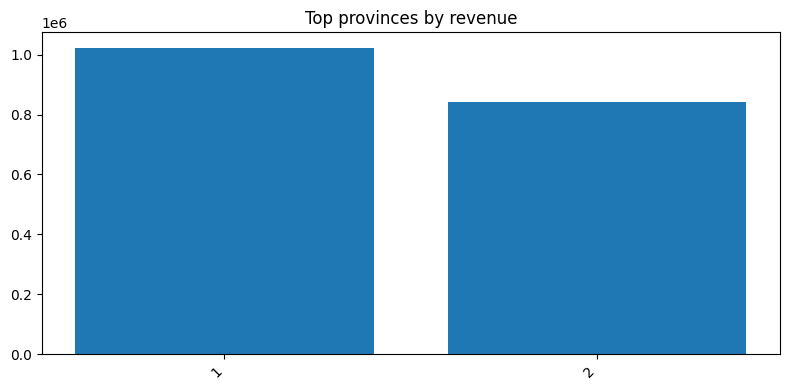

In [15]:
if {"amount"}.issubset(df.columns) and ("province_label" in df.columns or "province" in df.columns):
    col = "province_label" if "province_label" in df.columns else "province"
    prov = df.groupby(col, as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
    plt.figure(figsize=(8,4)); plt.bar(prov[col].astype(str), prov["amount"])
    plt.xticks(rotation=45, ha="right"); plt.title("Top provinces by revenue")
    plt.tight_layout()
    plt.savefig(REPORT / "fig_top_provinces.png", dpi=150)
    prov.to_csv(REPORT / "table_revenue_by_province.csv", index=False)


In [16]:
if {"supermarket_no","amount"}.issubset(df.columns):
    stores = df.groupby("supermarket_no", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
    plt.figure(figsize=(8,4)); plt.bar(stores["supermarket_no"].astype(str), stores["amount"])
    plt.xticks(rotation=45, ha="right"); plt.title("Top stores by revenue")
    plt.tight_layout()
    plt.savefig(REPORT / "fig_top_stores.png", dpi=150)
    stores.to_csv(REPORT / "table_top_stores.csv", index=False)


In [17]:
lines = []
# promo flag
df["promo_flag"] = 0
for c in ["feature","display"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({"nan":"0","None":"0"})
        df.loc[df[c].ne("0"), "promo_flag"] = 1

uplift = np.nan
if {"amount","promo_flag"}.issubset(df.columns):
    g = df.groupby("promo_flag")["amount"].mean()
    base, promo = g.get(0, np.nan), g.get(1, np.nan)
    if pd.notna(base) and base != 0 and pd.notna(promo):
        uplift = (promo - base) / base * 100
lines.append(f"Promotion uplift (mean amount): {'N/A' if pd.isna(uplift) else f'{uplift:.2f}%'}")

if "province_label" in df.columns and "amount" in df.columns:
    p5 = df.groupby("province_label", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5)
    lines.append("\nTop provinces:");  [lines.append(f"- {r.province_label}: {r.amount:.0f}") for r in p5.itertuples()]

if {"supermarket_no","amount"}.issubset(df.columns):
    s5 = df.groupby("supermarket_no", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5)
    lines.append("\nTop stores:");     [lines.append(f"- {r.supermarket_no}: {r.amount:.0f}") for r in s5.itertuples()]

if {"code","amount"}.issubset(df.columns):
    i5 = df.groupby("code", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5)
    lines.append("\nTop items:");      [lines.append(f"- {r.code}: {r.amount:.0f}") for r in i5.itertuples()]

(REPORT / "insights_to_paste.md").write_text("\n".join(lines), encoding="utf-8")
print("Wrote:", (REPORT / 'insights_to_paste.md').resolve())


Wrote: C:\Users\sik2k\Git_Repo\supermart-analytics-assignment\report\insights_to_paste.md


In [20]:
print("month nunique:", df["month"].nunique() if "month" in df.columns else "no month")
print("year_week nunique:", df["year_week"].nunique() if "year_week" in df.columns else "no year_week")
if "transaction_time" in df.columns:
    print("min:", df["transaction_time"].min(), "max:", df["transaction_time"].max())


month nunique: 1
year_week nunique: 1
min: 1970-01-01 00:00:00 max: 1970-01-01 00:00:00.000002359
